## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail</a> is a transnational dataset which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Source
UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/online+retail

## Business Goal
To segment the Customers based on RFM so that the company can target its customers efficiently.

## Methodology

1. [Reading and Understanding the Data](#1) <br>
    a. Creating a Data Dictionary
2. [Data Cleaning](#2)
3. [Data Preparation](#3) <br>
    a. Scaling Variables
4. [Model Building](#4) <br>
    a. K-means Clustering <br>
    b. Finding the Optimal K
5. [Final Analysis](#5)

<a id="1"></a> <br>
### 1 : Data Preprocessing

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly as py 
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
data = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')

In [3]:
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


In [4]:
data.shape

(541909, 8)

#### Data Dictionary 

First Header  | Definition    |  Description  | Data Type
------------- | ------------- | ------------- | -------------
InvoiceNo  | Invoice number | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. | Nominal
StockCode | Product (item) code | A 5-digit integral number uniquely assigned to each distinct product. | Nominal
Description | Product (item) name | Name of Product | Nominal
Quantity | Quantity | The quantities of each product (item) per transaction | Numeric
InvoiceDate | Invoice Date and time | The day and time when each transaction was generated. | Numeric
UnitPrice | Unit price | Product price per unit in sterling. | Numeric
CustomerID | Customer number | A 5-digit integral number uniquely assigned to each customer. | Nominal
Country | Country name | The name of the country where each customer resides. | Nominal

In [5]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There are a lot of `CustomerID` values that are null. While there are a few `Description` values that are null, they are useless. For rows with null `CustomerID`s, it is not interpretable so it is better to drop them

<Axes: >

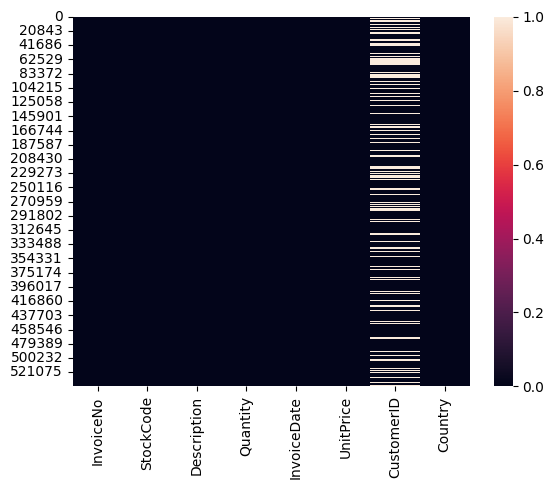

In [6]:
sns.heatmap(data.isna())

By removing those records with null values, we get the following heatmap

<Axes: >

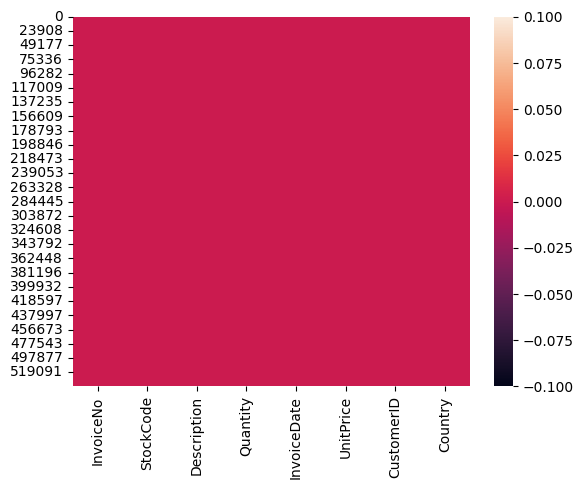

In [7]:
df = data.dropna(subset='CustomerID')

sns.heatmap(df.isna())

With the following statistics for null values for each column

In [8]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Checking `InvoiceNo`

In [9]:
ar = df[~df.InvoiceNo.str.match('[0-9]{6}')]
ar

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,01-12-2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01-12-2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01-12-2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,09-12-2011 09:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,09-12-2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,09-12-2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,09-12-2011 11:58,1.25,17315.0,United Kingdom


The `InvoiceNo` often has these values that have a prepended "C" for each number

In [10]:
ar.InvoiceNo.str.replace('[0-9]', '', regex=True).unique()

array(['C'], dtype=object)

In [11]:
data.InvoiceNo.str.replace('[0-9]', '', regex=True).unique()

array(['', 'C', 'A'], dtype=object)

Upon further analysis, it seems that there are other prepends such as "A" and "" for the `InvoiceNo` but since, we chose to drop the records with null values, they are now irrelevant

In [12]:
ar.Quantity.describe()

count     8905.000000
mean       -30.859966
std       1170.154939
min     -80995.000000
25%         -6.000000
50%         -2.000000
75%         -1.000000
max         -1.000000
Name: Quantity, dtype: float64

The "C" appears to have all negative values in `Quantity`. Which makes sense since they are recorded as cancellations

It has been decided that these `C[0-9]{6}' records for `InvoiceNo` will not be removed as they can be used for aggregations later to check the cancelled orders

In [57]:
ind = df[~df.InvoiceNo.str.fullmatch('[0-9]{6,}')].index

In [59]:
df = df.drop(index=ind)

### `StockCode` Analysis

In [13]:
df.StockCode = df.StockCode.astype(str)

C:\Users\araza\AppData\Local\Temp\ipykernel_13608\4066165662.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df[~df.StockCode.str.fullmatch('[A-Z0-9]{5}')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
45,536370,POST,POSTAGE,3,01-12-2010 08:45,18.00,12583.0,France
...,...,...,...,...,...,...,...,...
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,09-12-2011 12:16,4.15,12713.0,Germany
541809,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,09-12-2011 12:19,1.79,17581.0,United Kingdom
541838,581580,84993A,75 GREEN PETIT FOUR CASES,2,09-12-2011 12:20,0.42,12748.0,United Kingdom
541844,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,09-12-2011 12:20,1.25,12748.0,United Kingdom


about 35809 rows do not conform to the standard format of `StockCode`

In [15]:
Single_Letter = df[df['StockCode'].str.len() == 1]

Double_Letter = df[df['StockCode'].str.len() == 2]

Triple_Letter = df[df['StockCode'].str.len() == 3]

four_letter = df[df['StockCode'].str.len() == 4]

Stock_Code_Description = pd.concat([Single_Letter,Double_Letter, Triple_Letter, four_letter])
Stock_Code_Description

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,01-12-2010 09:41,27.50,14527.0,United Kingdom
2239,536569,M,Manual,1,01-12-2010 15:35,1.25,16274.0,United Kingdom
2250,536569,M,Manual,1,01-12-2010 15:35,18.95,16274.0,United Kingdom
6798,536981,M,Manual,2,03-12-2010 14:26,0.85,14723.0,United Kingdom
7976,537077,M,Manual,12,05-12-2010 11:59,0.42,17062.0,United Kingdom
...,...,...,...,...,...,...,...,...
541198,581493,POST,POSTAGE,1,09-12-2011 10:10,15.00,12423.0,Belgium
541216,581494,POST,POSTAGE,2,09-12-2011 10:13,18.00,12518.0,Germany
541730,581570,POST,POSTAGE,1,09-12-2011 11:59,18.00,12662.0,Germany
541767,581574,POST,POSTAGE,2,09-12-2011 12:09,18.00,12526.0,Germany


In [16]:
df[df.StockCode.str.fullmatch('[a-zA-Z0-9]{6,}')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 09:02,2.55,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,09-12-2011 12:16,4.15,12713.0,Germany
541809,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,09-12-2011 12:19,1.79,17581.0,United Kingdom
541838,581580,84993A,75 GREEN PETIT FOUR CASES,2,09-12-2011 12:20,0.42,12748.0,United Kingdom
541844,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,09-12-2011 12:20,1.25,12748.0,United Kingdom


In [17]:
ss = df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique().tolist()

These values above are the usual values that are not 5 digit codes

Since these values do not conform to the format provided by the data dictionary, they will be dropped

In [18]:
ind = df[~df.StockCode.str.fullmatch('[0-9]{5}')].index

In [19]:
df = df.drop(index=ind)

In [20]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


### `Country` analysis

In [21]:
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Austria', 'Israel',
       'Finland', 'Sweden', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

Those that do not conform to the format often have a meaning in of itself. The table above shows all of the non-conforming records and show that they all have a meaning that is often a one-to-one code for the `Description`

### `CustomerID`

In [22]:
df[df.CustomerID % 1 == 0].shape

(371020, 8)

all of the values in `CustomerID` are integers so its safe to cast them to `int`

In [23]:
df.CustomerID = df.CustomerID.astype(int)

In [24]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Austria', 'Israel',
       'Finland', 'Sweden', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

There are some countries that are named quite peculiar. This includes:
- European Community - There are countries that are already part of the european union like lithuania, poland and more. This european community might be 
the group of european countries excluding the former soviet countries like poland, lithuania and more.
- Channel Islands - "Channel Islands" is a geographical term, not a political unit.
- RSA - Republic of south Africa
- Unspecified 
-  EIRE - Éire is the Irish Gaelic name for "Ireland"

### `InvoiceDate`

Convert to datetime to query for date-sensitive plots

In [25]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate, dayfirst=True, format='mixed')

Filling the `CustomerID` with some value is incorrect because those values actually mean something other than the number it represents; it is a code. By filling them with one value such as 0 or something random, the column would either lose meaning in the values it holds or those filled with zero would be interpreted as one person

In [26]:
df.to_csv('data.csv')

<a id="2"></a> <br>
### 2 : EDA

In [60]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,363119.000000,363119,363119.000000,363119.000000
mean,13.129062,2011-07-12 18:02:10.770683904,2.886098,15295.738347
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-10 11:33:00,1.250000,13969.000000
50%,6.000000,2011-08-03 10:49:00,1.700000,15159.000000
75%,12.000000,2011-10-21 14:49:00,3.750000,16794.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,188.527851,NaN,4.361971,1711.946809


<Axes: xlabel='Quantity', ylabel='Count'>

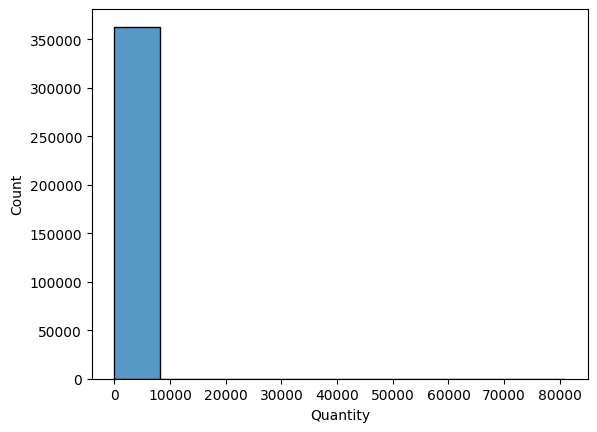

In [63]:
sns.histplot(df.Quantity, bins=10)

<Axes: ylabel='UnitPrice'>

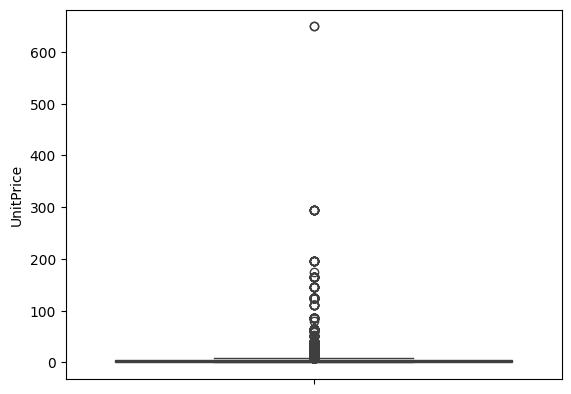

In [67]:
sns.boxplot(df.UnitPrice)

As observed, both `Quantity`, and `UnitPrice` are both heavily skewed and squished due to the extremely large outliers within the dataset

<Axes: xlabel='Country'>

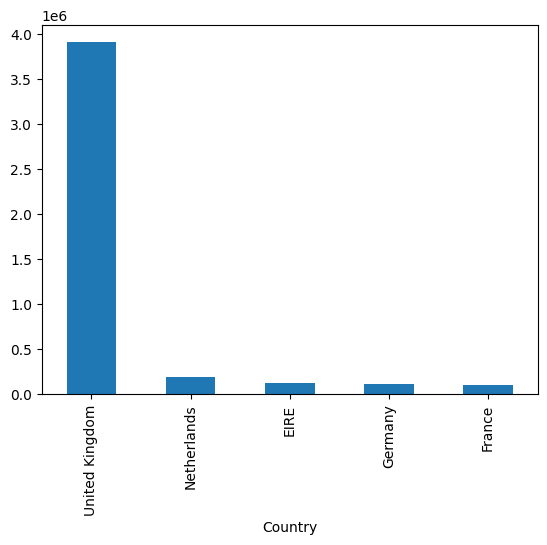

In [72]:
df.groupby('Country').Quantity.sum().nlargest(5).plot(kind='bar')

United Kingdom has the highest amount of `Quantity` meaning they buy a lot by a huge margin

<Axes: xlabel='Country'>

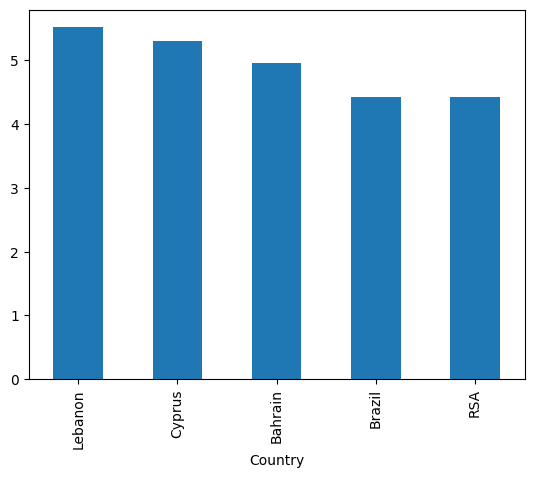

In [77]:
df.groupby('Country').UnitPrice.mean().nlargest(5).plot(kind='bar')

According to the grouping, Lebanon, Cyprus, Bahrain, etc. have the highest averages for `UnitPrice`, meeaning that a lot of their prices are for each stock are high

In [79]:
df[['Quantity', 'UnitPrice']].corr()

,Quantity,UnitPrice
Quantity,1.000000,-0.019235
UnitPrice,-0.019235,1.000000


In the numerical columns `Quantity` and `UnitPrice`

<a id="3"></a> <br>
### 3 : Data Preparation

#### Customers will be analyzed based on 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [ ]:
# New Attribute : Monetary


In [ ]:
# New Attribute : Frequency


In [ ]:
# Merging the two dfs


In [ ]:
# New Attribute : Recency

# Convert to datetime to proper datatype


In [ ]:
# Compute the maximum date to know the last transaction date



In [ ]:
# Compute the difference between max date and transaction date


In [ ]:
# Compute last transaction date to get the recency of customers


In [ ]:
# Extract number of days only



In [ ]:
# Merge tha dataframes to get the final RFM dataframe


#### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.<br>
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardization (mean-0, sigma-1) 

Here we execute Standard Scaling.

In [ ]:
# Rescaling the attributes

# Instantiate

# fit_transform


## <span style="color: red;">Execute MinMax Scaling in the next box</span> 

<a id="4"></a> <br>
### 4 : Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [ ]:
# k-means with some arbitrary k


In [ ]:
#create a K_means function here


In [ ]:
#plot your clusters


## <span style="color: red;">Finding the Optimal Number of Clusters</span> 

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

## <span style="color: red;">Box Plots of Clusters created</span> 

<a id="5"></a> <br>
## Step 5 : Final Analysis

## <span style="color: red;">Findings</span> 

#### Student Name: